# Query and consolidate median household income and population data by Illinois census tract

In [1]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import os
from datetime import datetime
import requests, json

# display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# display plots in ipynb
%matplotlib inline

# Median household income

In [2]:
# request data from census api
r = requests.get("https://api.census.gov/data/2017/acs/acs5?get=NAME,B19013_001E&for=tract:*&in=state:17&in=county:*")

In [3]:
# json to dictionary
income_data = r.json()
income_data[:5] # looking at first five elements

[['NAME', 'B19013_001E', 'state', 'county', 'tract'],
 ['Census Tract 8810.02, Will County, Illinois',
  '88203',
  '17',
  '197',
  '881002'],
 ['Census Tract 8811.05, Will County, Illinois',
  '121463',
  '17',
  '197',
  '881105'],
 ['Census Tract 8805.02, Will County, Illinois',
  '85913',
  '17',
  '197',
  '880502'],
 ['Census Tract 8837, Will County, Illinois', '48516', '17', '197', '883700']]

In [4]:
# convert dictionary to df
income_df = pd.DataFrame(income_data[1:], columns = income_data[0]).rename(columns={
    "B19013_001E":"median_household_income"})

# display first five rows
income_df.head()

,NAME,median_household_income,state,county,tract
0,"Census Tract 8810.02, Will County, Illinois",88203,17,197,881002
1,"Census Tract 8811.05, Will County, Illinois",121463,17,197,881105
2,"Census Tract 8805.02, Will County, Illinois",85913,17,197,880502
3,"Census Tract 8837, Will County, Illinois",48516,17,197,883700
4,"Census Tract 8801.05, Will County, Illinois",90172,17,197,880105


In [5]:
# split the NAME column on the comma
income_df[["census_tract_name", "county_name", "state_name"]] = income_df["NAME"].str.split(", ", expand = True)

In [6]:
# now that the column is split, remove "NAME" column
del income_df["NAME"]

In [7]:
# create a fips (five digit code for the county) column
income_df["fips"] = income_df["state"] + income_df["county"]

#### create a census tract code (this consists of state|county|tract)

In [8]:
# create a census tract code by pasting 'state', 'county' and 'tract' columns
income_df['census_tract'] = income_df['state'] + income_df['county'] + income_df['tract']

In [9]:
# display first five rows
income_df.head()

,median_household_income,state,county,tract,census_tract_name,county_name,state_name,fips,census_tract
0,88203,17,197,881002,Census Tract 8810.02,Will County,Illinois,17197,17197881002
1,121463,17,197,881105,Census Tract 8811.05,Will County,Illinois,17197,17197881105
2,85913,17,197,880502,Census Tract 8805.02,Will County,Illinois,17197,17197880502
3,48516,17,197,883700,Census Tract 8837,Will County,Illinois,17197,17197883700
4,90172,17,197,880105,Census Tract 8801.05,Will County,Illinois,17197,17197880105


In [10]:
# info on the table
income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 9 columns):
median_household_income    3123 non-null object
state                      3123 non-null object
county                     3123 non-null object
tract                      3123 non-null object
census_tract_name          3123 non-null object
county_name                3123 non-null object
state_name                 3123 non-null object
fips                       3123 non-null object
census_tract               3123 non-null object
dtypes: object(9)
memory usage: 219.7+ KB


In [11]:
# median_household_income to numeric
income_df["median_household_income"] = pd.to_numeric(income_df["median_household_income"])

In [12]:
# descriptive stats on the table
# .apply portion removes scientific notation
income_df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,median_household_income
count,3123.000000
mean,-2711894.628242
std,42933830.140104
min,-666666666.000000
25%,42310.000000
50%,57447.000000
75%,78000.500000
max,250001.000000


#### It was a bit surprising to see a min value of -666666666.000000. Code below will show what values appear below 0.

In [13]:
# unique median_household
print(income_df.median_household_income[income_df.median_household_income < 0].unique())

# count of said unique values under 0
print(income_df.median_household_income[income_df.median_household_income < 0].value_counts())

[-666666666]
-666666666    13
Name: median_household_income, dtype: int64


In [14]:
# what census_tract values have this median household income?
income_df[income_df.median_household_income.isin([-666666666])]

,median_household_income,state,county,tract,census_tract_name,county_name,state_name,fips,census_tract
1085,-666666666,17,197,980000,Census Tract 9800,Will County,Illinois,17197,17197980000
1228,-666666666,17,087,980000,Census Tract 9800,Johnson County,Illinois,17087,17087980000
1480,-666666666,17,097,990000,Census Tract 9900,Lake County,Illinois,17097,17097990000
1532,-666666666,17,201,980000,Census Tract 9800,Winnebago County,Illinois,17201,17201980000
1581,-666666666,17,019,000302,Census Tract 3.02,Champaign County,Illinois,17019,17019000302
1660,-666666666,17,031,990000,Census Tract 9900,Cook County,Illinois,17031,17031990000
1661,-666666666,17,031,980000,Census Tract 9800,Cook County,Illinois,17031,17031980000
1670,-666666666,17,097,863006,Census Tract 8630.06,Lake County,Illinois,17097,17097863006
1671,-666666666,17,097,863005,Census Tract 8630.05,Lake County,Illinois,17097,17097863005
2462,-666666666,17,031,381700,Census Tract 3817,Cook County,Illinois,17031,17031381700


In [15]:
# do any of those census_tract values appear more than once?
negative_census_tract = income_df[income_df.median_household_income.isin([-666666666])]['census_tract']

# sum ocurrence of these census tracts across entire df
income_df['census_tract'].isin(negative_census_tract.tolist()).sum()

13

#### So it was just that one very negative value, and it occurred for 13 records. The code below will filter out the -666666666 from the df.

In [16]:
# subset income_df to rows with median_household_income > 0
income_df_sub = income_df.query('median_household_income > 0')
income_df_sub.shape

(3110, 9)

# Bring in population

In [17]:
# second request - this time for population
r2 = requests.get("https://api.census.gov/data/2017/acs/acs5?get=NAME,B01001_001E&for=tract:*&in=state:17&in=county:*")
print(r2)

<Response [200]>


In [18]:
# json to dictionary
pop_data = r2.json()
pop_data[:5] # looking at first five rows

# convert dictionary to df
pop_df = pd.DataFrame(pop_data[1:], columns = pop_data[0]).rename(columns={
    "B01001_001E":"population"})

# display first five rows
pop_df.head()

,NAME,population,state,county,tract
0,"Census Tract 8810.02, Will County, Illinois",5186,17,197,881002
1,"Census Tract 8811.05, Will County, Illinois",6394,17,197,881105
2,"Census Tract 8805.02, Will County, Illinois",5180,17,197,880502
3,"Census Tract 8837, Will County, Illinois",3127,17,197,883700
4,"Census Tract 8801.05, Will County, Illinois",7590,17,197,880105


#### As with median household income, split the "NAME" column.

In [19]:
# split the NAME column on the comma
pop_df[["census_tract_name", "county_name", "state_name"]] = pop_df["NAME"].str.split(", ", expand = True)

In [20]:
# now that the column is split, remove "NAME" column
del pop_df["NAME"]

In [21]:
# create a fips (five digit code for the county) column
pop_df["fips"] = pop_df["state"] + pop_df["county"]

#### Also, as with income, create a census tract number from state, county, and tract

In [22]:
pop_df['census_tract'] = pop_df['state'] + pop_df['county'] + pop_df['tract']

In [23]:
# info
print(pop_df.info())

# display first five rows as well
pop_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 9 columns):
population           3123 non-null object
state                3123 non-null object
county               3123 non-null object
tract                3123 non-null object
census_tract_name    3123 non-null object
county_name          3123 non-null object
state_name           3123 non-null object
fips                 3123 non-null object
census_tract         3123 non-null object
dtypes: object(9)
memory usage: 219.7+ KB
None


,population,state,county,tract,census_tract_name,county_name,state_name,fips,census_tract
0,5186,17,197,881002,Census Tract 8810.02,Will County,Illinois,17197,17197881002
1,6394,17,197,881105,Census Tract 8811.05,Will County,Illinois,17197,17197881105
2,5180,17,197,880502,Census Tract 8805.02,Will County,Illinois,17197,17197880502
3,3127,17,197,883700,Census Tract 8837,Will County,Illinois,17197,17197883700
4,7590,17,197,880105,Census Tract 8801.05,Will County,Illinois,17197,17197880105


In [24]:
# population to numeric
pop_df["population"] = pd.to_numeric(pop_df["population"])

In [25]:
# descriptive stats on table
pop_df.describe(include='all')

,population,state,county,tract,census_tract_name,county_name,state_name,fips,census_tract
count,3123.000000,3123,3123,3123,3123,3123,3123,3123,3123
unique,NaN,1,102,2584,2584,102,1,102,3123
top,NaN,17,031,000200,Census Tract 2,Cook County,Illinois,17031,17031828702
freq,NaN,3123,1319,13,13,1319,3123,1319,1
mean,4116.082613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1989.276739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2764.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3849.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,5132.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


How many census tracts have 0 people?

In [26]:
# sort by lowest population
pop_df['population'].value_counts().reset_index().sort_values(by = 'index').rename(
    columns = {'index':'population', 'population':'record count'})[:10]

,population,record count
0,0,7
1156,8,1
2137,341,1
1694,475,1
623,507,1
1445,592,1
732,660,1
1400,689,1
1328,736,1
1563,783,1


## Combine income and pop tables

Code below will allow for displaying multiple objects from one cell output. Code pulled from [Jake Vanderplas' book](https://jakevdp.github.io/PythonDataScienceHandbook/03.06-concat-and-append.html)

In [27]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

In [28]:
# display first five rows of income and population dataframes
display('income_df_sub.head()', 'pop_df.head()')

,median_household_income,state,county,tract,census_tract_name,county_name,state_name,fips,census_tract
0,88203,17,197,881002,Census Tract 8810.02,Will County,Illinois,17197,17197881002
1,121463,17,197,881105,Census Tract 8811.05,Will County,Illinois,17197,17197881105
2,85913,17,197,880502,Census Tract 8805.02,Will County,Illinois,17197,17197880502
3,48516,17,197,883700,Census Tract 8837,Will County,Illinois,17197,17197883700
4,90172,17,197,880105,Census Tract 8801.05,Will County,Illinois,17197,17197880105
,population,state,county,tract,census_tract_name,county_name,state_name,fips,census_tract
0,5186,17,197,881002,Census Tract 8810.02,Will County,Illinois,17197,17197881002
1,6394,17,197,881105,Census Tract 8811.05,Will County,Illinois,17197,17197881105
2,5180,17,197,880502,Census Tract 8805.02,Will County,Illinois,17197,17197880502
3,3127,17,197,883700,Census Tract 8837,Will County,Illinois,17197,17197883700


In [29]:
# is the tract a unique key?
display("pop_df['census_tract'].value_counts().reset_index().head()",
        "income_df['census_tract'].value_counts().reset_index().head()") 

,index,census_tract
0,17031828702,1
1,17031804709,1
2,17183000900,1
3,17097863006,1
4,17031260100,1
,index,census_tract
0,17031828702,1
1,17031804709,1
2,17183000900,1
3,17097863006,1


In [30]:
# join two tables on 'tract' and 'fips'
combined = pd.merge(income_df_sub, pop_df, on = 'census_tract', how = 'left',
                   suffixes = ('_income_df', '_pop_df'))
print(combined.shape)
combined.head()

(3110, 17)


,median_household_income,state_income_df,county_income_df,tract_income_df,census_tract_name_income_df,county_name_income_df,state_name_income_df,fips_income_df,census_tract,population,state_pop_df,county_pop_df,tract_pop_df,census_tract_name_pop_df,county_name_pop_df,state_name_pop_df,fips_pop_df
0,88203,17,197,881002,Census Tract 8810.02,Will County,Illinois,17197,17197881002,5186,17,197,881002,Census Tract 8810.02,Will County,Illinois,17197
1,121463,17,197,881105,Census Tract 8811.05,Will County,Illinois,17197,17197881105,6394,17,197,881105,Census Tract 8811.05,Will County,Illinois,17197
2,85913,17,197,880502,Census Tract 8805.02,Will County,Illinois,17197,17197880502,5180,17,197,880502,Census Tract 8805.02,Will County,Illinois,17197
3,48516,17,197,883700,Census Tract 8837,Will County,Illinois,17197,17197883700,3127,17,197,883700,Census Tract 8837,Will County,Illinois,17197
4,90172,17,197,880105,Census Tract 8801.05,Will County,Illinois,17197,17197880105,7590,17,197,880105,Census Tract 8801.05,Will County,Illinois,17197


# Explore combined table

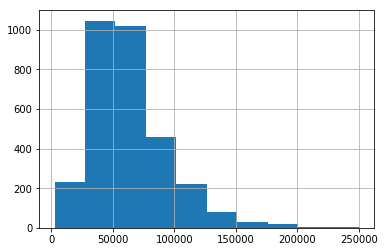

In [31]:
# looking at histogram of median household income in Illinois 
combined.median_household_income.hist()

In [32]:
# what is the median value?
combined.median_household_income.median()

57650.0

Important caveat on above median: It is the median value looking at tract level, but would be different if looking statewide (about $62,000).

What are the unique values in the FIPS column?

In [33]:
# count of unique values in 'fips' column
print(combined['fips_income_df'].nunique())

# unique values in 'fips' column
print(combined['fips_income_df'].unique())

102
['17197' '17031' '17097' '17043' '17143' '17089' '17067' '17119' '17063'
 '17091' '17131' '17037' '17173' '17163' '17047' '17079' '17081' '17201'
 '17177' '17191' '17193' '17203' '17055' '17113' '17111' '17161' '17001'
 '17027' '17185' '17019' '17147' '17153' '17169' '17175' '17045' '17005'
 '17083' '17155' '17039' '17051' '17103' '17009' '17121' '17101' '17133'
 '17139' '17145' '17107' '17117' '17159' '17165' '17123' '17125' '17075'
 '17021' '17049' '17077' '17093' '17105' '17127' '17171' '17179' '17017'
 '17187' '17099' '17199' '17167' '17183' '17115' '17033' '17085' '17065'
 '17069' '17149' '17151' '17189' '17135' '17195' '17057' '17061' '17073'
 '17025' '17003' '17129' '17157' '17059' '17141' '17181' '17023' '17041'
 '17137' '17071' '17109' '17007' '17013' '17035' '17053' '17087' '17095'
 '17011' '17015' '17029']


What census tract has the highest income?

In [34]:
# return row with max value for 'median_household_income'
combined.iloc[combined['median_household_income'].idxmax()]

median_household_income                   250001
state_income_df                               17
county_income_df                             031
tract_income_df                           800100
census_tract_name_income_df    Census Tract 8001
county_name_income_df                Cook County
state_name_income_df                    Illinois
fips_income_df                             17031
census_tract                         17031800100
population                                  2574
state_pop_df                                  17
county_pop_df                                031
tract_pop_df                              800100
census_tract_name_pop_df       Census Tract 8001
county_name_pop_df                   Cook County
state_name_pop_df                       Illinois
fips_pop_df                                17031
Name: 2618, dtype: object

# Final clean up and export

In [35]:
combined.head()

,median_household_income,state_income_df,county_income_df,tract_income_df,census_tract_name_income_df,county_name_income_df,state_name_income_df,fips_income_df,census_tract,population,state_pop_df,county_pop_df,tract_pop_df,census_tract_name_pop_df,county_name_pop_df,state_name_pop_df,fips_pop_df
0,88203,17,197,881002,Census Tract 8810.02,Will County,Illinois,17197,17197881002,5186,17,197,881002,Census Tract 8810.02,Will County,Illinois,17197
1,121463,17,197,881105,Census Tract 8811.05,Will County,Illinois,17197,17197881105,6394,17,197,881105,Census Tract 8811.05,Will County,Illinois,17197
2,85913,17,197,880502,Census Tract 8805.02,Will County,Illinois,17197,17197880502,5180,17,197,880502,Census Tract 8805.02,Will County,Illinois,17197
3,48516,17,197,883700,Census Tract 8837,Will County,Illinois,17197,17197883700,3127,17,197,883700,Census Tract 8837,Will County,Illinois,17197
4,90172,17,197,880105,Census Tract 8801.05,Will County,Illinois,17197,17197880105,7590,17,197,880105,Census Tract 8801.05,Will County,Illinois,17197


#### Define columns to keep and select those columns

In [36]:
combined.columns

Index(['median_household_income', 'state_income_df', 'county_income_df',
       'tract_income_df', 'census_tract_name_income_df',
       'county_name_income_df', 'state_name_income_df', 'fips_income_df',
       'census_tract', 'population', 'state_pop_df', 'county_pop_df',
       'tract_pop_df', 'census_tract_name_pop_df', 'county_name_pop_df',
       'state_name_pop_df', 'fips_pop_df'],
      dtype='object')

In [37]:
# mask to be used to filter
cols_to_keep = ['fips_income_df', 'tract_income_df', 'census_tract', 'county_name_income_df',
                'state_name_income_df', 'median_household_income', 'population']

# filter on above mask
combined_2 = combined[cols_to_keep]

In [38]:
# display first five rows
combined_2.head()

,fips_income_df,tract_income_df,census_tract,county_name_income_df,state_name_income_df,median_household_income,population
0,17197,881002,17197881002,Will County,Illinois,88203,5186
1,17197,881105,17197881105,Will County,Illinois,121463,6394
2,17197,880502,17197880502,Will County,Illinois,85913,5180
3,17197,883700,17197883700,Will County,Illinois,48516,3127
4,17197,880105,17197880105,Will County,Illinois,90172,7590


In [39]:
# rename the columns
combined_final = combined_2.rename(columns = {'fips_income_df': 'fips',
                                              'tract_income_df': 'tract',
                                              'county_name_income_df': 'county_name',
                                              'state_name_income_df': 'state'})

# print shape of final file
print(combined_final.shape)

# display first five rows
combined_final.head()

(3110, 7)


,fips,tract,census_tract,county_name,state,median_household_income,population
0,17197,881002,17197881002,Will County,Illinois,88203,5186
1,17197,881105,17197881105,Will County,Illinois,121463,6394
2,17197,880502,17197880502,Will County,Illinois,85913,5180
3,17197,883700,17197883700,Will County,Illinois,48516,3127
4,17197,880105,17197880105,Will County,Illinois,90172,7590


#### Write above table to CSV

In [40]:
# write to outputs folder (one level up, then outputs)
# using to_excel to maintain 'fips', 'tract', and 'census_tract' columns as character
combined_final.to_excel("../outputs/Illinois_Median_Household_Income_and_Population_by_Tract.xlsx",
                        index = False)